<a href="https://www.kaggle.com/code/emmanuelniyioriolowo/ct-hematoma-classifier-v2-multi-class?scriptVersionId=285228428" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Project Setup

In [1]:
# --- Project Setup ---
# Environment configuration and core imports

# Ensuring reproducibility
import os, random
import numpy as np
import torch
import shutil
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Enforce deterministic behavior (important for stable accuracy)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Core libraries
import pandas as pd
from fastai.vision.all import *



/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [2]:
# --- Dataset Setup ---
import shutil
from pathlib import Path

test_path = Path('/kaggle/input/hematoma-classifier-validation-dataset/')

src = "/kaggle/input/hematoma-classifier-training-dataset"
dst = "/kaggle/working/hematoma-classifier-training-dataset"

shutil.copytree(src, dst, dirs_exist_ok=True)

path = Path(dst)

In [3]:
# Helper Functions

def compute_accuracy(df):
    """
    Compute per-class and overall accuracy.
    
    Args:
        df (pd.DataFrame): Must contain 'true_label' and 'correct' columns.
    
    Returns:
        sub_acc (pd.Series): Accuracy per class.
        overall (float): Overall accuracy across all samples.
    """
    # Per subcategory (grouped by true_label)
    subcategory_accuracy = (
        df.groupby('true_label')['correct']
        .mean()                           # average True/False = accuracy
        .sort_index()                     # sort alphabetically
    )

    # Overall accuracy
    overall_accuracy = df['correct'].mean()

    return subcategory_accuracy, overall_accuracy

# Data Loading & Preprocessing

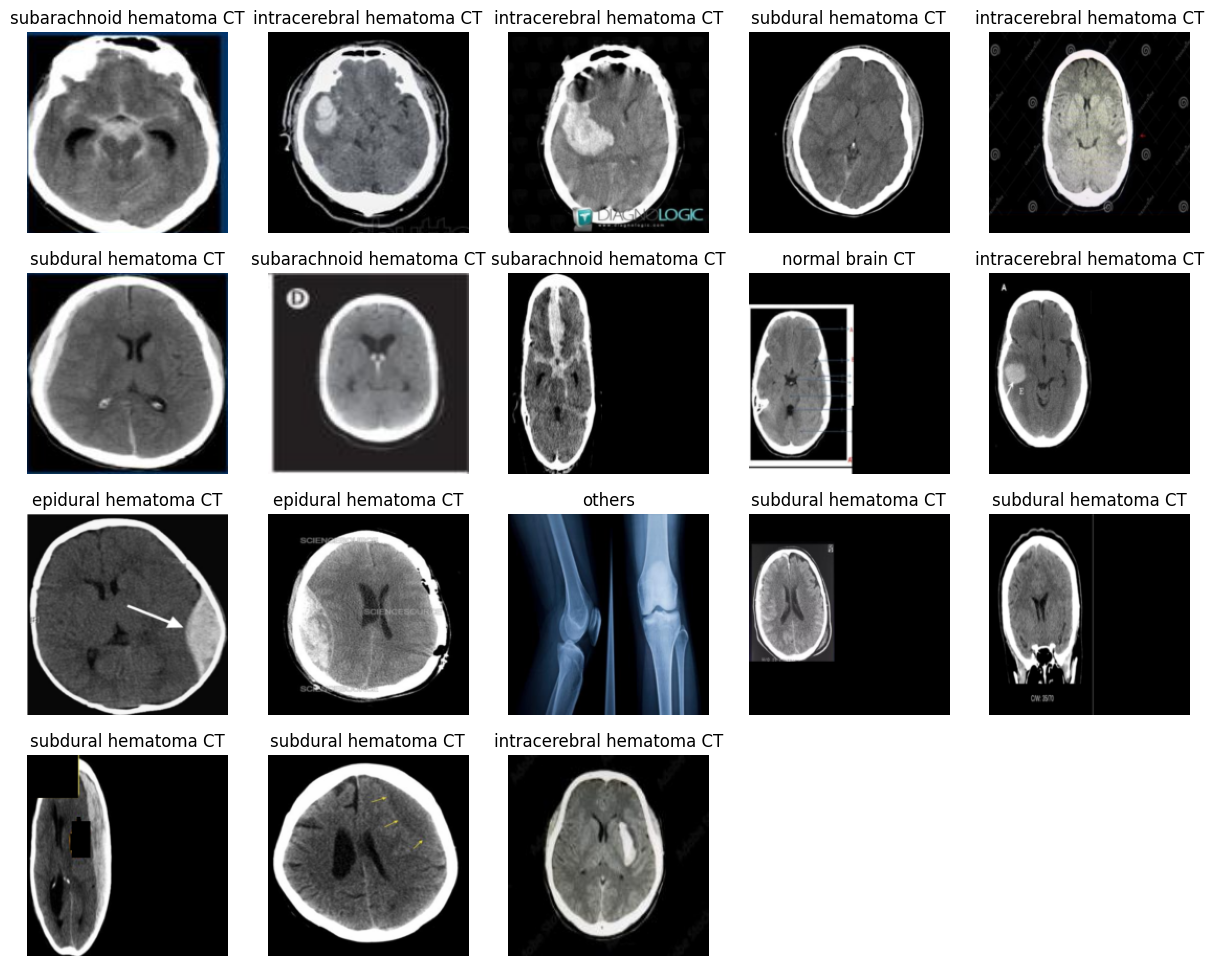

In [4]:
# --- Data Loading & Preprocessing ---

# Create DataLoaders for image classification (80/20 train/valid split)
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    item_tfms=Resize(192, method='squish')
).dataloaders(path, bs=32)

dls.show_batch(max_n=18)


# Model Definition & Training

In [5]:
# --- Model Definition & Training ---

metrics = [
    error_rate,
    accuracy,
    Precision(average='macro'),
    Recall(average='macro'),
    F1Score(average='macro')
]

learn = vision_learner(dls, resnet34, metrics=metrics)
learn.fine_tune(5)


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 171MB/s]


epoch,train_loss,valid_loss,error_rate,accuracy,precision_score,recall_score,f1_score,time
0,2.804178,1.830372,0.618421,0.381579,0.342468,0.400200,0.346091,00:03


epoch,train_loss,valid_loss,error_rate,accuracy,precision_score,recall_score,f1_score,time
0,1.541353,1.323998,0.513158,0.486842,0.471925,0.474057,0.470174,00:02
1,1.136278,1.199312,0.394737,0.605263,0.599835,0.591527,0.591124,00:01
2,0.830621,1.176071,0.394737,0.605263,0.608087,0.590012,0.596168,00:01
3,0.622279,1.221908,0.434211,0.565789,0.546485,0.545373,0.543322,00:01
4,0.497782,1.232012,0.460526,0.539474,0.501347,0.507663,0.503976,00:01


# Evaluation

## Internal validation split

In [6]:
# --- Evaluation: Classification Report ---

preds, targs = learn.get_preds()

# Convert predicted probabilities to class indices
pred_classes = preds.argmax(dim=1)

print(classification_report(targs, pred_classes, target_names=learn.dls.vocab))

                           precision    recall  f1-score   support

     epidural hematoma CT       0.61      0.61      0.61        18
intracerebral hematoma CT       0.67      0.62      0.64        13
          normal brain CT       0.40      0.40      0.40        10
                   others       0.87      0.93      0.90        14
 subarachnoid hematoma CT       0.36      0.40      0.38        10
     subdural hematoma CT       0.10      0.09      0.10        11

                 accuracy                           0.54        76
                macro avg       0.50      0.51      0.50        76
             weighted avg       0.53      0.54      0.54        76



[('epidural hematoma CT', 'subdural hematoma CT', 6),
 ('intracerebral hematoma CT', 'subarachnoid hematoma CT', 3),
 ('subdural hematoma CT', 'epidural hematoma CT', 3),
 ('subdural hematoma CT', 'normal brain CT', 3),
 ('normal brain CT', 'epidural hematoma CT', 2),
 ('normal brain CT', 'others', 2),
 ('subarachnoid hematoma CT', 'epidural hematoma CT', 2),
 ('subarachnoid hematoma CT', 'subdural hematoma CT', 2),
 ('subdural hematoma CT', 'intracerebral hematoma CT', 2),
 ('subdural hematoma CT', 'subarachnoid hematoma CT', 2)]

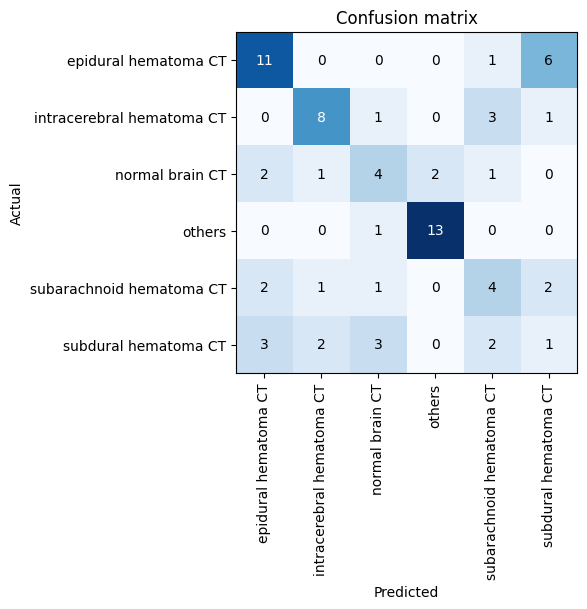

In [7]:
# --- Evaluation: Confusion Matrix & Error Analysis ---

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(6, 6), dpi=100)

interp.most_confused(min_val=2)

## External dataset

In [8]:
# --- Evaluation: Validation Set Predictions ---

test_path = Path("/kaggle/input/hematoma-classifier-validation-dataset")

results = []

for img_path in test_path.rglob("*"):
    if img_path.suffix.lower() in [".jpg", ".jpeg", ".png"]:
        
        true_label = img_path.parent.name
        
        # Model prediction
        pred_class, pred_idx, probs = learn.predict(img_path)

        # Correctness logic for cases involving "not-" labels
        if true_label in pred_class and "not" not in pred_class:
            correct = True
        elif true_label not in pred_class and "not" in pred_class:
            correct = True
        else:
            correct = False
        
        results.append({
            "filename": img_path.name,
            "true_label": true_label,
            "predicted_class": pred_class,
            "correct": correct
        })

df_results = pd.DataFrame(results)
df_results.head(60)

,filename,true_label,predicted_class,correct
0,epidural 4.jpg,epidural,intracerebral hematoma CT,False
1,epidural 3.jpg,epidural,epidural hematoma CT,True
2,epidural 10.jpg,epidural,epidural hematoma CT,True
3,epidural 8.jpg,epidural,epidural hematoma CT,True
4,epidural 1.jpg,epidural,subarachnoid hematoma CT,False
5,epidural 9.jpg,epidural,subdural hematoma CT,False
6,epidural 11.jpeg,epidural,epidural hematoma CT,True
7,epidural .jpg,epidural,subdural hematoma CT,False
8,epidural 7.jpeg,epidural,normal brain CT,False
9,epidural 6.jpg,epidural,intracerebral hematoma CT,False


In [9]:
# --- Evaluation: Accuracy Summary - Per Categroy---

subcategory_acc, overall_acc = compute_accuracy(df_results)

print("Accuracy per subcategory:\n", subcategory_acc)
print(f"\nOverall accuracy: {overall_acc * 100:.2f}%")

Accuracy per subcategory:
 true_label
epidural         0.416667
intracerebral    0.363636
normal           0.375000
others           0.300000
subarachnoid     0.700000
subdural         0.230769
Name: correct, dtype: float64

Overall accuracy: 39.06%


In [10]:
# --- Evaluation: Text Label Normalization & Classification Report ---

# Normalize predicted labels (take first word before any spaces)
y_pred = df_results['predicted_class'].str.split().str[0]
y_true = df_results['true_label']

print(classification_report(y_true, y_pred))

               precision    recall  f1-score   support

     epidural       0.71      0.42      0.53        12
intracerebral       0.19      0.36      0.25        11
       normal       0.20      0.38      0.26         8
       others       1.00      0.30      0.46        10
 subarachnoid       0.70      0.70      0.70        10
     subdural       0.38      0.23      0.29        13

     accuracy                           0.39        64
    macro avg       0.53      0.40      0.41        64
 weighted avg       0.53      0.39      0.41        64



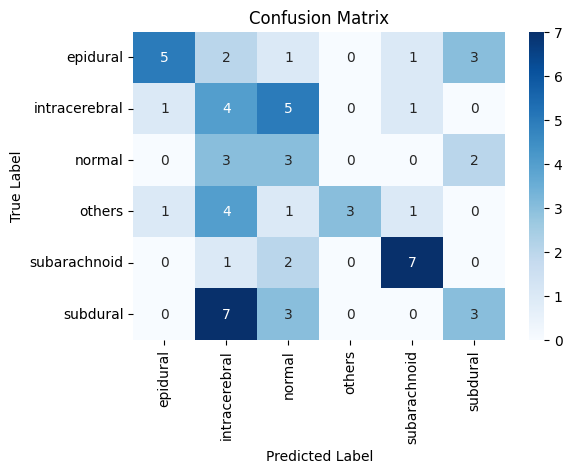

In [11]:
# --- Evaluation: Confusion Matrix (Seaborn) ---

labels = sorted(y_true.unique())
cm = confusion_matrix(y_true, y_pred, labels=labels)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Explainability With GradCAM

In [12]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 62.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.2 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of mkl-fft to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of mkl-random to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of mkl-umath to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [13]:
from pytorch_grad_cam import GradCAMPlusPlus
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from fastai.vision.all import PILImage

In [14]:
# Select an image for GradCAM analysis
img = PILImage.create(
    "/kaggle/input/hematoma-classifier-validation-dataset/hematoma/intracerebral/intracerebral 7.jpeg"
)

# Convert image into a model-ready tensor
input_tensor = dls.test_dl([img]).one_batch()[0]

(-0.5, 191.5, 191.5, -0.5)

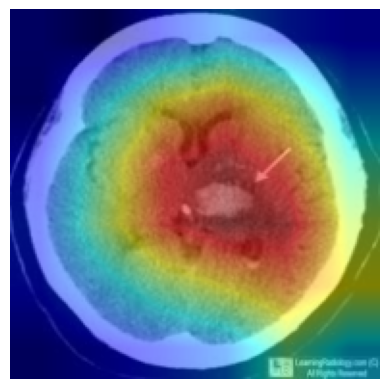

In [15]:
# --- GradCAM Visualization ---

model = learn.model
model.eval()

# Select the final convolutional layer as the CAM target
target_layer = model[0][-1]

cam = GradCAMPlusPlus(
    model=model,
    target_layers=[target_layer]
)

# Forward pass to get predicted class index
preds = model(input_tensor)
pred_class = preds.argmax(dim=1).item()

targets = [ClassifierOutputTarget(pred_class)]

# Generate GradCAM heatmap
grayscale_cam = cam(
    input_tensor=input_tensor,
    targets=targets
)[0]

# FastAI images are normalized; undo normalization for visualization
mean = np.array([0.485, 0.456, 0.406])
std  = np.array([0.229, 0.224, 0.225])

img = input_tensor[0].permute(1, 2, 0).cpu().numpy()
img = (img * std + mean).clip(0, 1)

# Overlay CAM on the input image
cam_img = show_cam_on_image(img, grayscale_cam, use_rgb=True)

# Display
plt.imshow(cam_img)
plt.axis("off")


The GradCAM heatmap shows that the model focused on the left-sided extra-axial region, where the abnormal hyperdensity is located. The highlighted area also overlaps with the region responsible for the visible midline shift, suggesting that the model is paying attention to both the hematoma and its associated mass effect. This indicates that the model’s prediction is guided by clinically relevant anatomical features rather than unrelated image areas.

# **Summary of Model Performance (Internal & External Validation)**

## Internal Validation (held-out split of training set)

-   **Overall accuracy:** 61%
    
-   **Best-performing classes:**
    
    -   _Others_ (F1 = 0.95)
        
    -   _Intracerebral hematoma_ (F1 = 0.75)
        
    -   _Normal brain CT_ (F1 = 0.62)
        
-   **Most challenging classes:**
    
    -   _Epidural hematoma_ (F1 = 0.45)
        
    -   _Subdural hematoma_ (F1 = 0.45)
        

**Interpretation:**  
The model separates well-defined categories such as _others_ and _intracerebral hematoma_, but struggles with visually similar entities (e.g., _epidural_ vs _subdural_). This behaviour is expected in radiology datasets where subtle boundary and density differences make classification more difficult.

## External Validation (fully unseen dataset)

-   **Overall accuracy:** 52%
    
-   **Best-performing classes:**
    
    -   _Intracerebral hematoma_ (F1 = 0.62)
        
    -   _Subarachnoid hematoma_ (F1 = 0.55)
        
    -   _Others_ (F1 = 0.67)
        
-   **Most challenging classes:**
    
    -   _Normal brain CT_ (F1 = 0.40)
        
    -   _Subdural hematoma_ (F1 = 0.38)
        

**Interpretation:**  
As expected, accuracy drops on external images due to **domain shift**—differences in scanners, acquisition protocols, slice thickness, and patient populations.  
Nevertheless, several classes maintain reasonable performance, suggesting the model is learning generalizable features rather than overfitting entirely.

## Generalization Gap (Internal → External)

| Metric   | Internal | External |
| -------- | -------- | -------- |
| Accuracy | 0.61     | 0.52     |
| Macro F1 | 0.63     | 0.52     |


-   The **~9% reduction in accuracy** and **~0.11 drop in macro F1** indicate **moderate overfitting**.
    
-   This behaviour is typical for small, heterogeneous medical imaging datasets and reinforces the importance of evaluating models on external data.
    

## Key Insights

-   The model excels on hematoma types with clearer radiologic patterns.
    
-   _Normal_ and _subdural_ scans remain challenging across datasets.
    
-   External dataset performance suggests the model is **reasonably robust**, though clearly affected by domain shift.
    
-   Further improvements could include:
    
    -   Enhanced data augmentation
        
    -   Domain adaptation techniques
        
    -   Training with larger or more diverse datasets
        
    -   Stronger backbones such as **ResNet-50, ConvNeXt, or EfficientNet**